# 2. Features and Vectors

## 2.1 Extraction and Vectorization

In stylometry, feature vectors are numerical representations of text segments and their lexical composition.  Hence, vectors guarantee an objective basis for comparability of texts. The power of this, is that algorithms can process textual characteristics automatically, simultaneously, fast and on a large scale, often disregarding word order (the **bag-of-words** approach). A vector α, filled with the feature frequencies of text α, after all, becomes a solid basis for comparison with vectors β, γ, ... which in their own turn represent the stylistic properties of text samples β, γ, ... This common ground allows to approach stylistic difference literally as **mathematical difference** and (as we will see when visualizing the data) **geometric distance**.

Before we get started, first run the code below again (copy of preprocessing code from the previous notebook) in order to make our text data manipulable. 

In [1]:
import glob
import os
import re
from string import punctuation

current_directory = os.getcwd() # gets current directory
folder_path = current_directory + '/corpus/train' # gets directory path to corpus folder containing .txt files

# Declare empty lists to fill up with our metadata and data
authors = []
titles = []
texts = []

# We declare some parameters — the 'settings' of our stylometric experiments
sample_len = 1400 # word length of text segment

# Open all file objects in folder and gather data
for filename in glob.glob(folder_path + '/*'):
    author = filename.split("/")[-1].split(".")[0].split("_")[0]
    title = filename.split("/")[-1].split(".")[0].split("_")[1]

    bulk = []
    text = open(filename, encoding='utf-8-sig').read() # utf-8-sig encoding automatically handles and removes Unicode Byte Order Mark (BOM) if present

    # .split() method splits string into list of substrings based on a specified delimiter. By default, the delimiter is a whitespace
    # .strip() method removes leading and trailing whitespace from a string: spaces, tabs, newlines, and other whitespace characters.
    for word in text.strip().split(): 
        word = re.sub('\d+', '', word) # escape digits
        word = re.sub('[%s]' % re.escape(punctuation), '', word) # escape punctuation
        word = word.lower() # convert upper to lowercase
        bulk.append(word)

    # Split up the text into discrete chunks or segments
    bulk = [word for word in bulk if word != ""] # list comprehension that removes emptry strings
    bulk = [bulk[i:i+sample_len] for i in range(0, len(bulk), sample_len)]
    for index, sample in enumerate(bulk):
        if len(sample) == sample_len:
            authors.append(author)
            titles.append(title + "_{}".format(str(index + 1)))
            texts.append(" ".join(sample))

The **[scikit-learn](https://scikit-learn.org/stable/index.html) "Machine Learning in Python"-library** offers tremendously handy modules and transformers to extract features in a format supported by machine learning algorithms. 

Below, we initialize our first vectorizer, under the variable `model`, which helps extract the textual features we are interested in (`word`, `char`, meaning respectively 'word' or 'character'), the number of features (`max_features=20`), but which can also be helpful to eliminate words that are irrelevant to our focus (`stop_words`), or where we can feed a restrictive list of words in advance that narrows the selection down (`vocabulary`) would be a comprehensive list containing those features which you want to look at exclusively). The `n_gram` range, consequently, formulates the sequences of *n* characters / words / parts-of-speech one wants to look at.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize sklearn vectorizer model
model = CountVectorizer(stop_words=[], # filter words
                        max_features=20, # n features = vector length / vector dimensionality.
                        analyzer='word', # feature type
                        vocabulary=None, # takes list of fixed words
                        ngram_range=((1,1))) 

X = model.fit_transform(texts).toarray()
print(X)

[[12 10 17 ...  5  0 13]
 [12  8  9 ... 18 13 10]
 [10  6  9 ... 12  6  7]
 ...
 [11 12  6 ...  4  3 19]
 [13 14  5 ... 10  1 17]
 [12 20 12 ...  7  1 15]]


The result of this process, the matrix `X` printed above, is our very first matrix containing vectors representing the feature frequencies of each of our text segments. The `toarray()` converts X into a standard array format, typically `numpy`-array.  
In `X`, each row equals a text segment. Every column stands for the frequency of an extracted feature.

In the code block below, we make the above more intuitive by representing `X`in a so-called DataFrame (abbreviated as `df`) using `pandas`. This is an open-source data analysis and manipulation library in Python that provides data structures and functions needed to manipulate structured data.

In [5]:
import pandas as pd

df = pd.DataFrame(X) # structures matrix X as a DataFrame
features = model.get_feature_names_out()

# Assigns labels to columns and rows (i.e. features and title segments)
df.columns = features # assigns column labels
df.index = [title for title in titles] # assigns row labels

print(df)

                           ad  cum  de  dei  enim  est  et  in  nec  non  per  \
Epistolae_1                12   10  17   11     4   14  86  29    1   11    4   
Epistolae_2                12    8   9    2     5   22  54  28    6   22    3   
Epistolae_3                10    6   9    7     6   44  58  26    3   48    1   
Epistolae_4                14    2  15    4    10   18  48  38    7   43    2   
Epistolae_5                14   11  22    8     5   13  51  39    4   29    0   
...                        ..  ...  ..  ...   ...  ...  ..  ..  ...  ...  ...   
Liber-diuinorum-operum_78  12   16   9    8     2   13  84  73    5    9    6   
Liber-diuinorum-operum_79  20   15   4    6     3   14  81  61    9    7    9   
Liber-diuinorum-operum_80  11   12   6    6     4   15  58  51    5   15   18   
Liber-diuinorum-operum_81  13   14   5   10     4   13  54  63    5    5   19   
Liber-diuinorum-operum_82  12   20  12   14     6   21  63  55    5    5   20   

                           

At this point, the scikit-learn feature extraction model still sorts the columns by alphabet rather than by frequency. The code below shows you how to refit your vectorizer so the vectors, somewhat more intuitively, descend from higher to lower frequency.

In [7]:
import numpy as np

# Sum the feat frequencies across all documents (i.e. text segments)
feat_frequencies = np.asarray(X.sum(axis=0)).flatten()

# Get the feature names (features)
features = model.get_feature_names_out()

# Create a DataFrame with features and their frequencies
feat_freq_df = pd.DataFrame({'feature': features, 'frequency': feat_frequencies})

# Sort the DataFrame by frequency in descending order
feat_freq_df = feat_freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

# Get the sorted features
sorted_features = feat_freq_df['feature'].tolist()

# Reorder the columns of the matrix X according to the sorted features
sorted_indices = [model.vocabulary_[feat] for feat in sorted_features]
X_sorted = X[:, sorted_indices]

# Print the sorted feature names and their corresponding frequencies
print(feat_freq_df)
print(sorted_features)

   feature  frequency
0       et      16145
1       in       9761
2      est       4470
3      non       3797
4       ad       3651
5       ut       3649
6      que       3255
7     quod       3032
8      cum       2802
9      qui       2622
10      de       2503
11     sed       2249
12     per       2079
13      si       1734
14    quia       1652
15      se       1497
16    quam       1333
17     nec       1286
18     dei       1235
19    enim       1171
['et', 'in', 'est', 'non', 'ad', 'ut', 'que', 'quod', 'cum', 'qui', 'de', 'sed', 'per', 'si', 'quia', 'se', 'quam', 'nec', 'dei', 'enim']


Now you can refit a new `CountVectorizer` on our texts by feeding the `sorted_features`container to the `vocab` parameter of the vectorizer.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize sklearn model
model = CountVectorizer(stop_words=[], 
                        max_features=20,
                        analyzer='word',
                        vocabulary=sorted_features,
                        ngram_range=((1,1)))

X = model.fit_transform(texts).toarray()

df = pd.DataFrame(X)
features = model.get_feature_names_out()

# Assigns names to columns and features (i.e. features and title segments)
df.columns = features
df.index = [title for title in titles]

print(df)

                           et  in  est  non  ad  ut  que  quod  cum  qui  de  \
Epistolae_1                86  29   14   11  12  13    7     6   10    5  17   
Epistolae_2                54  28   22   22  12  10   11     6    8    9   9   
Epistolae_3                58  26   44   48  10   7   12     6    6    6   9   
Epistolae_4                48  38   18   43  14  13   11     7    2   11  15   
Epistolae_5                51  39   13   29  14   9    8     7   11    8  22   
...                        ..  ..  ...  ...  ..  ..  ...   ...  ...  ...  ..   
Liber-diuinorum-operum_78  84  73   13    9  12  10   22     1   16    7   9   
Liber-diuinorum-operum_79  81  61   14    7  20  13   11    15   15    6   4   
Liber-diuinorum-operum_80  58  51   15   15  11  19   16     8   12   19   6   
Liber-diuinorum-operum_81  54  63   13    5  13  17   23    14   14   20   5   
Liber-diuinorum-operum_82  63  55   21    5  12  15   16     7   20   16  12   

                           sed  per  si

Try to work with different settings, and then look at the various results in the extraction and vectorization process.

Below we introduce another common type of vectorization called **TF-IDF-vectorization**, which stands for ‘term frequency-inverse document frequency’, see C. D. Manning, P. Raghavan, and H. Schütze, *Introduction to Information Retrieval* (New York, Cambridge University Press, 2008), at 289-290. It divides all feature values by the number of documents that respective feature appears in. As a consequence, less common features receive a higher weight, which prevents them from sinking away (and from losing statistical significance) amidst more common features. You can try to fit a TfidfVectorizer to your own dataset by running the code block below.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize sklearn model
model = TfidfVectorizer(stop_words=[], 
                        max_features=20,
                        analyzer='word',
                        vocabulary=sorted_features,
                        ngram_range=((1,1)))

X = model.fit_transform(texts).toarray()

df = pd.DataFrame(X)
features = model.get_feature_names_out()

# Assigns names to columns and features (i.e. features and title segments)
df.columns = features
df.index = [title for title in titles]

print(df)

                                 et        in       est       non        ad  \
Epistolae_1                0.873046  0.294399  0.142124  0.111669  0.121820   
Epistolae_2                0.699541  0.362725  0.284998  0.284998  0.155453   
Epistolae_3                0.603213  0.270406  0.457610  0.499211  0.104002   
Epistolae_4                0.548241  0.434024  0.205590  0.491133  0.159904   
Epistolae_5                0.613696  0.469297  0.156432  0.348965  0.168466   
...                             ...       ...       ...       ...       ...   
Liber-diuinorum-operum_78  0.704608  0.612338  0.109046  0.075494  0.100658   
Liber-diuinorum-operum_79  0.735982  0.554258  0.127207  0.063603  0.181724   
Liber-diuinorum-operum_80  0.632157  0.555862  0.163489  0.163489  0.119892   
Liber-diuinorum-operum_81  0.546987  0.638151  0.131682  0.050647  0.131682   
Liber-diuinorum-operum_82  0.636262  0.555467  0.212087  0.050497  0.121193   

                                 ut       que      

## 2.2 Distance Measures and Scaling

### 2.2.1 Understanding Distance: Burrows' Delta

Popularly applied to look at distances between vectors in the recent history of computational stylistics, are **John Burrows’** distance measures **Delta** (2002), **Zeta** and **Iota**. Burrows' methods, especially Delta, proved invaluable in the development of stylometry in its own time, and continues to provide an intuitive introduction to stylometric research. Due to the proliferation and improved understanding of the mathematical-statistical precepts underlying his theory, applying Delta by itself is not often carried out anymore and has become a tad outdated. We will explain why below.

With Delta, Burrows essentially operationalized and matched two data-analytical steps: he first **'normalized'** or **'scaled'** the frequencies of words, and afterward calculated a **distance** between these vectors. The scaling implied that Burrows ‘standardized’ the word frequencies over the whole corpus so that the mean for each word is 0, and the standard deviation is 1, also known as the ‘z-score’. Consequently, he applied the so-called 'Manhattan' distance, to be treated further below. 

It turns out that Burrows' way of normalizing and measuring distance was, however, just one of many ways in which to conceptualize the distance between vectors. Argamon (2008) showed that, despite it being very effective, it may even not necessarily be the most optimal way. There have been several proposals to improve Delta (Hoover 2004b, Argamon 2008, Eder, Smith and Aldridge 2011, Kestemont and Rybicki 2013). 

If we want to implement Burrows' Delta in Python, we have to normalize our text vectors in `X` by transforming them to z scores, which can easily be done by importing `StandardScaler()` from `sklearn`. Consequently, we can apply the distance metric **Manhattan** (`sklearn.metrics.pairwise`) to calculate the similarity between the data points of a test text and a target corpus. Note that we should not necessarily opt for Manhattan distance. Other distance metrics, especially **Euclidean** and **Cosine**, provide valuable routes that can (and in fact should) be tested in performance. There are quite a few distance measures (or distance functions) around, but arguably they are are all variations falling under one of these three commonly encountered measures.

* **Manhattan** or ‘taxicab distance’ has its onomasty in a city street plan, is a distance function which measures two points along axes at right angles, indeed, as if one would be navigating in a city along city blocks.
* **Euclidean** distance is commonly the most straightforward way of going from one place to another, and can be generally thought of as the distance in which ‘the crow flies,’ directly fixing one point to another without taking any turns.
* **Cosine** instead measures the cosine of the angle between the points.

### 2.2.2 Scaling

More often than not, analysis will be carried out not on raw frequencies of features, but on ‘normalized’ or ‘weighted’ frequencies (feature scaling). In fact, TF-IDF is arguably already a (be it subtle) way of scaling feature frequencies. 

Scaling data is crucial in all statistical methods. It transforms the data to ensure that different features are on a similar scale. Key advantages are improved performance of data-analytical operations at a later stage, the equal importance (weight) granted by each of the respective features in the dataset, and a more intuitive interpretability of the results.

With `sklearn.preprocessing` it is possible to import scaling models such as `Normalizer`, `StandardScaler`, `MinMaxScaler`, and many others, to apply scaling. The block of code below is an illustration.

In [13]:
from sklearn.preprocessing import StandardScaler
import numpy as np

np.set_printoptions(suppress=True, precision=2) # suppresses scientific notation 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[ 1.73 -1.   -0.71 ... -1.14  1.37 -0.36]
 [ 0.02 -0.44  1.28 ...  0.53 -0.6   0.43]
 [-0.93 -1.2   3.68 ... -0.62  0.48  0.35]
 ...
 [-0.65  1.14 -0.41 ... -0.05  0.31 -0.26]
 [-1.49  1.82 -0.85 ... -0.14  1.13 -0.36]
 [-0.61  1.14  0.27 ... -0.14  2.05  0.29]]


Once we have scaled vectors, various distance measures can be applied. The block of code below yields a matrix  of pairwise differences (with a dimension or `np.shape` of 250x250) between the text segment and all text segments in the corpus, including... itself! Obviously, the distance is 0 in that case.

Have a go and run the block of code below. For the first time, we will also use a plot (a heatmap) to visualize what is going on, making use of the Python library `matplotlib`. The heatmap visualizes the Manhattan distances between our text segment vectors. Each cell in the heatmap represents the distance between two vectors, with the color intensity indicating the magnitude of the distance. Darker colors correspond to smaller distances (i.e., more similar vectors), while lighter colors indicate larger distances (i.e., less similar vectors), see the color bar on the right provides. Both the x- and y-axes represent the indices of the vectors, making it possible to identify which vectors are being compared in each cell.

[[ 0.   22.88 24.06 ... 23.19 23.23 18.63]
 [22.88  0.   19.23 ... 23.19 27.16 21.93]
 [24.06 19.23  0.   ... 27.46 30.89 26.97]
 ...
 [23.19 23.19 27.46 ...  0.   10.72 12.99]
 [23.23 27.16 30.89 ... 10.72  0.   12.74]
 [18.63 21.93 26.97 ... 12.99 12.74  0.  ]]


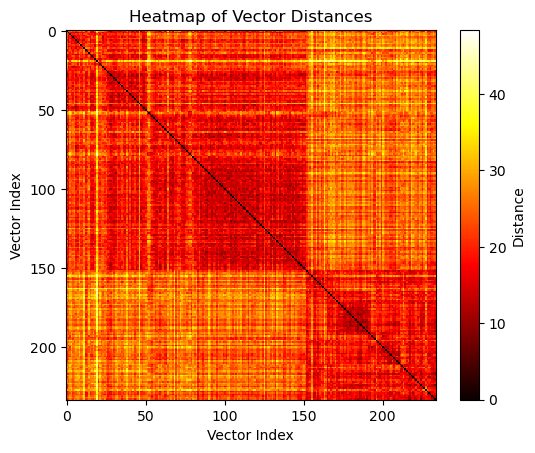

In [15]:
from sklearn.metrics.pairwise import manhattan_distances
import matplotlib.pyplot as plt
from datetime import datetime

distance_matrix = manhattan_distances(X_scaled)
print(distance_matrix)

# Plot a heatmap
fig = plt.figure()
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Heatmap of Vector Distances')
plt.xlabel('Vector Index')
plt.ylabel('Vector Index')
plt.show()

# Get the current time
current_time = datetime.now()
current_directory = os.getcwd() # gets current directory
folder_path = current_directory + '/output' # gets directory path to corpus folder containing .txt files
fig.savefig(folder_path + '/heatmap-{}.png'.format(current_time), dpi=300, transparent=True, format='png')

## 2.3 Feature Weighting and Feature Selection

Not to be confused with feature extraction, **feature selection** techniques penalize / filter out those features that are considered redundant, and reward or include only the best discriminants.

Sometimes, the selection or elimination of features is done manually on the basis of **qualitative** arguments (Kestemont et al. 2015:206). However, most feature selection base themselves on **quantitative** criteria (where a distinction is made between filter-based and wrapper-based methods). 

The classes in the `sklearn.feature_selection` are useful for feature selection/dimensionality reduction to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets. Machine-learning techniques, to be treated later today, can be particularly helpful in evaluating the efficiency and relevance of including or excluding certain features. This relevance is often determined by **weights**: establishing feature weights is often a first step toward a pruned and more efficient set of discriminants.

The idea that some words deserve less or more attention (again, deserve more **weight**) than others in attribution disputes is an idea that arose fairly early in stylometric research. Proposed by Hoover (2004), for instance, was '**culling**', where features that do not appear in all the representative texts of a corpus have to be disregarded. 

### 2.3.1 An Intuition through Burrows' and Craig's Zeta

Above, we already mentioned Burrows's '**Zeta**' in passing. Zeta was first proposed in 2007 and modified by other scholars (Argamon 2008, Craig and Kinney 2009, Hoover 2004a, 2004b). In what follows, we will explain Zeta just as one of many possible ways to think about feature selection. Two main reasons: (1) Zeta is a commonly encountered state-of-the-art technique stylometric research, and (2) unlike other feature selection methods, there is less available Python code lying around for it in libraries or modules.

John Burrows motivated the advantage of Zeta mainly from the idea that the frequency of a feature by itself can be misleading when talking about its significance for the author in question. It is, for instance, very possible that a certain word in a text occurs many times in the author's Prologue, but then again, for instance, fails to turn up later in the text. what we also need to take into account, he argued, is the **dispersion** of the word over a text or entire oeuvre. Instead of look at the frequencies of words, we concentrate on their consistency of appearance.

Some key ideas to take home:
* The original Zeta compared subcorpora by two and not more authors, **Author A** and **Author B** below, and we will do the same here.
* Zeta is about frequency per segment (**proportion** or **ratio**) rather than raw, total word count.
* Zeta is mainly about 'distinctiveness', i.e. **preference and avoidance** by Authors A or B: Zeta returns a list of words that are statistically either preferred or avoided in each subcorpus.
* As a consequence, we see that Zeta analysis often excludes the extremely common words that are traditionally the focus of stylometry, and concentrates on the **middle of the word frequency spectrum**, yielding a few extremely efficient features for making distinction between Author A and Author B.
* Sample or **segment length** is an important parameter in its performance.

As an additional parameter, you can also set a threshold: e.g. *w* needs to occur at least once per segment for one of both authors under consideration, before we consider it to have importance.

Zeta combines the ratio of the sections by one author in which each word occurs with the ratio of the sections by the other author into a single measure of 'distinctiveness' for each word. It does so by subtracting the zeta scores of Author B from that of Author A. This 'composite score' produces two lists of words: one favored by the first author and avoided by the second, the other favored by the second author and avoided by the first.

Concretely, this means: 
* words that score `0` are used by exactly the same frequency per segment by both Authors A and B.
* words that score `-1` are used by Author A in every segment, and not in any segment by Author B.
* words that score `1` are used by Author B in every segment, and not in any segment by Author A.

The code block below simply rehearses a lot we have seen earlier, only this time, we **vectorize the entire vocabulary** in a long feature vector, instead of only looking at the most common words.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
import glob
import numpy as np
import os
import pandas as pd
import re

current_directory = os.getcwd() # gets current directory
folder_path = current_directory + '/corpus/train' # gets directory path to corpus folder containing .txt files

# Declare empty lists to fill up with our metadata and data
authors = []
titles = []
texts = []

# We declare some parameters — the 'settings' of our stylometric experiments
sample_len = 1400 # word length of text segment

# Open all file objects in folder and gather data
for filename in glob.glob(folder_path + '/*'):
    author = filename.split("/")[-1].split(".")[0].split("_")[0]
    title = filename.split("/")[-1].split(".")[0].split("_")[1]

    bulk = []
    text = open(filename, encoding='utf-8-sig').read() # utf-8-sig encoding automatically handles and removes Unicode Byte Order Mark (BOM) if present

    # .split() method splits string into list of substrings based on a specified delimiter. By default, the delimiter is a whitespace
    # .strip() method removes leading and trailing whitespace from a string: spaces, tabs, newlines, and other whitespace characters.
    for word in text.strip().split(): 
        word = re.sub('\d+', '', word) # escape digits
        word = re.sub('[%s]' % re.escape(punctuation), '', word) # escape punctuation
        word = word.lower() # convert upper to lowercase
        bulk.append(word)

    # Split up the text into discrete chunks or segments
    bulk = [word for word in bulk if word != ""] # list comprehension that removes emptry strings
    bulk = [bulk[i:i+sample_len] for i in range(0, len(bulk), sample_len)]
    for index, sample in enumerate(bulk):
        if len(sample) == sample_len:
            authors.append(author)
            titles.append(title + "_{}".format(str(index + 1)))
            texts.append(" ".join(sample))

# In this vectorizer, for the purpose of Zeta, no max_features is given.
model = CountVectorizer(stop_words=[], # filter words
                        analyzer='word', # feature type
                        vocabulary=None, # takes list of fixed words
                        ngram_range=((1,1)))

X = model.fit_transform(texts).toarray()
features = model.get_feature_names_out()

print(features)
print(X.shape) # prints dimension (n_samples, n_feats)


['aar' 'aaron' 'ab' ... 'zizania' 'zizaniorum' 'zorobabel']
(234, 41572)


In the code block below, we first have to indicate which authors we are interested in by typing out the author names (corresponding to the file names) in the list variable `authors_of_interest`.

Consequently, we loop over matrix `X`, taking into account only the text segment vectors of interest, and crunch them into `bit_vectors`, or 'binarize them', in the sense that any frequency greater than `0` is simply converted into `1`.

We can consequently count (as we do in the line of code containing `counts = np.sum(bit_vector)`) how many times the word occurs more than 0 in each text segment. If we divide this number by the variable `n_segments`, we get a `ratio`.


In [23]:
# Two sets of texts by two authors, divided into about equal-sized sections
authors_of_interest = ['Hildegardis-Bingensis', 'Petrus-Cellensis'] # type names of authors in corpus whose texts you want to compare

new_X = {author: [] for author in authors_of_interest}
for author, title, x_vec in zip(authors, titles, X):
    if author in authors_of_interest:
        x_vec[x_vec > 0] = 1 # turns into bit_vector, i.e. converts feature counts greater than 0 to 1 (simply confirms presence or absence)
        new_X[author].append(x_vec)
new_X = {author: np.array(bit_matrix) for author, bit_matrix in new_X.items()}

ratios_dict = {author: None for author in authors_of_interest}
for author, bit_matrix in new_X.items():
    n_segments = bit_matrix.shape[0] # number of text segments for this author
    all_ratios = []
    for feat, bit_vector in zip(features, bit_matrix.transpose()): # .transpose() turns our matrix around
        counts = np.sum(bit_vector) # gets n segments in which the term occurs
        ratio = counts/n_segments # ratio = n_occurrences / n_samples
        all_ratios.append(ratio)
    ratios_dict[author] = all_ratios

# negative -1 means preference by Author A, 0 means same ratios for both Authors, positive +1 means preference by Author B
X_ratios = [all_ratios for all_ratios in ratios_dict.values()]
X_ratios = np.array(X_ratios).transpose()
y = [author for author in ratios_dict.keys()]

# Calculate Zeta
zeta_scores = X_ratios[:, 1] - X_ratios[:, 0]

negatives = [(x, weight) for weight, x in sorted(zip(zeta_scores, features))] # most negative values
positives = negatives[::-1] # [::-1] reverses a list

print(negatives[:10])
print(positives[:10])


[('quemadmodum', -0.9167862266857962), ('quoniam', -0.9093735054997609), ('quatinus', -0.8048780487804879), ('uelut', -0.8017694882831181), ('quapropter', -0.7242945958871353), ('homo', -0.6936872309899569), ('ipsius', -0.6793400286944047), ('hominem', -0.6719273075083693), ('ostendit', -0.6219512195121951), ('scientia', -0.6166905786704926)]
[('imo', 0.8823529411764706), ('tanquam', 0.8431372549019608), ('quis', 0.8287900526064085), ('petrus', 0.7991391678622668), ('abbas', 0.7525107604017216), ('igitur', 0.7407938785270206), ('nostra', 0.7403156384505021), ('uobis', 0.7137733142037302), ('uestra', 0.7085126733620277), ('certe', 0.693687230989957)]


As you can imagine, these words are powerfull stuff! They hand us quite effectively a number of discriminants that work very well in distinguishing two authors' lexical preferences from one another, and the usefulness of the discriminants is not confined by membership in the high frequency strata.

Below, we visualize our results by using `matplotlib` once more.

The variable `n_visualized` stands for 'number visualized': indicate how many of the top discriminants you wish to plot.

Consequently, take a good look at this plot, and try to verify if this makes sense to you on a qualitative level!

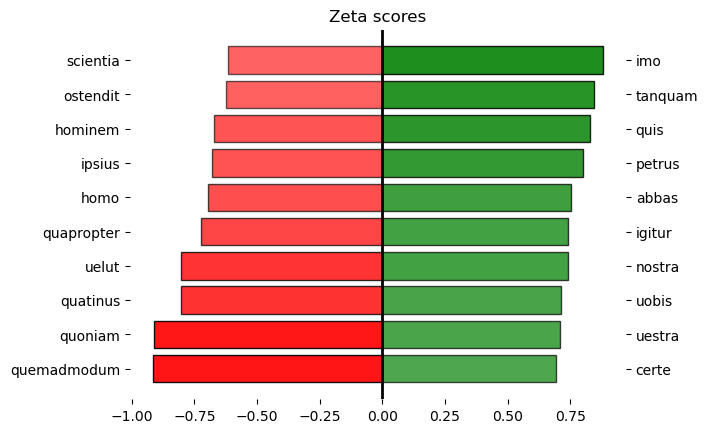

In [25]:
from datetime import datetime
import matplotlib.pyplot as plt

# Parameters
n_visualized = 10 # number of terms based on Zeta score visualized

# Plot
fig, ax = plt.subplots()

# store Zeta data in variables
x_negatives = [tup[1] for tup in negatives[:n_visualized]]
x_positives = [tup[1] for tup in positives[:n_visualized]][::-1]
y = [i for i in range(0, n_visualized )]

# plot the values
for x_coord, y_coord in zip(y, x_positives):
    ax.barh(x_coord, y_coord, color='g', edgecolor='black', alpha=np.abs(y_coord))
for x_coord, y_coord in zip(y, x_negatives):
    ax.barh(x_coord, y_coord, color='r', edgecolor='black', alpha=np.abs(y_coord))

# labelling the axes
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
bottom_labels = [tup[0] for tup in negatives[:n_visualized]]
top_labels = [tup[0] for tup in positives[:n_visualized][::-1]]
ax.set_yticks(y)
ax.set_yticklabels(bottom_labels)
ax2.set_yticks(y)
ax2.set_yticklabels(top_labels)

plt.title('Zeta scores')

# Despine both axes
for spine in ['right', 'top', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

plt.axvline(x=0, lw=2, c='black', zorder=1)

# Get the current time
current_time = datetime.now()
current_directory = os.getcwd() # gets current directory
folder_path = current_directory + '/output' # gets directory path to corpus folder containing .txt files
fig.savefig(folder_path + '/zeta-{}.png'.format(current_time), dpi=300, transparent=True, format='png')
